In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import misc
import numpy as np
import pytesseract
from PIL import Image

In [197]:
# Define required parameters
dir = r'C:\Users\ankuarora\Desktop\Client\2017_05_CogEx\2017_07_R2Implementation\Sprint 6\SampleInputs'
in_file = r'scanned letter 8.jpg'
in_dir_file = os.path.join(dir,in_file)

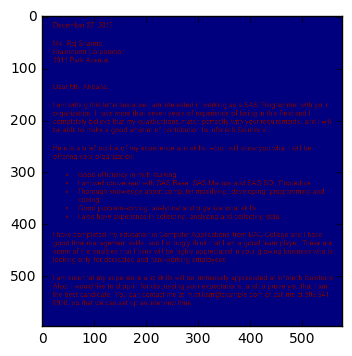

(<matplotlib.image.AxesImage at 0x1ca045c8588>, None)

In [227]:
image = cv2.imread(in_dir_file,0)
p_image = cv2.bitwise_not(image)
# threshold the image, setting all foreground pixels to 255 and all background pixels to 0
p_image = cv2.threshold(p_image, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(p_image), plt.show()

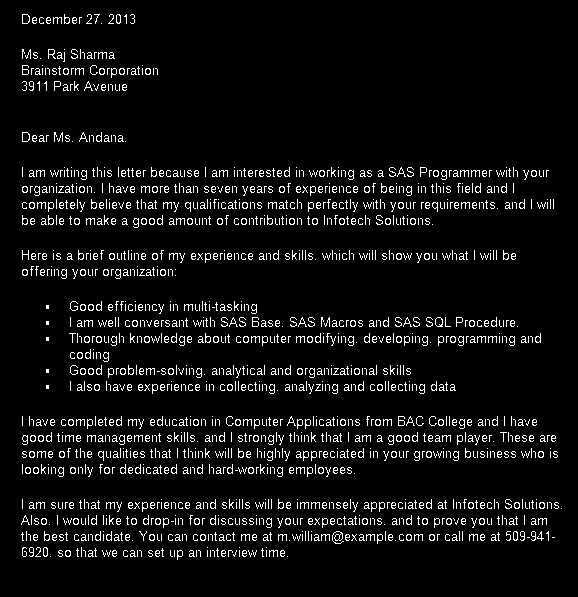

In [228]:

misc.toimage(p_image)

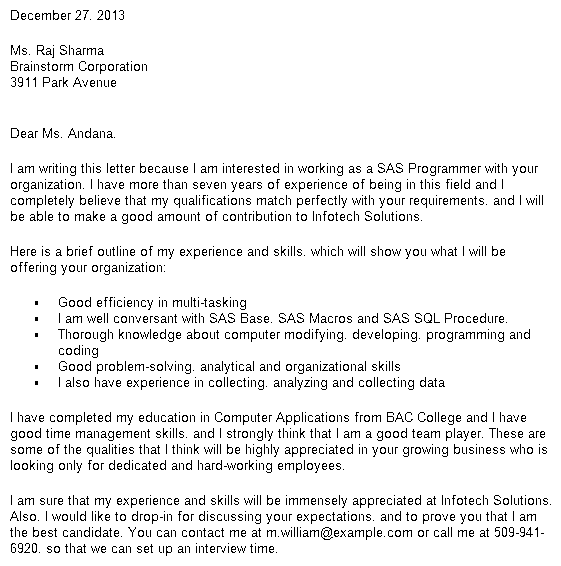

In [229]:
coords = np.column_stack(np.where(p_image > 0))
x,y,w,h = cv2.boundingRect(coords)
image = cv2.threshold(image, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
misc.toimage(image)
image_sliced = image[x-10:x+w+10,y-10:y+h+10]
misc.toimage(image_sliced)

In [201]:
# find lines by horizontally blurring the image and thresholding
blur = cv2.blur(image_sliced, (91,9))
b_mean = np.mean(blur, axis=1)/255
threshold = np.percentile(b_mean, 66)
t = b_mean > threshold

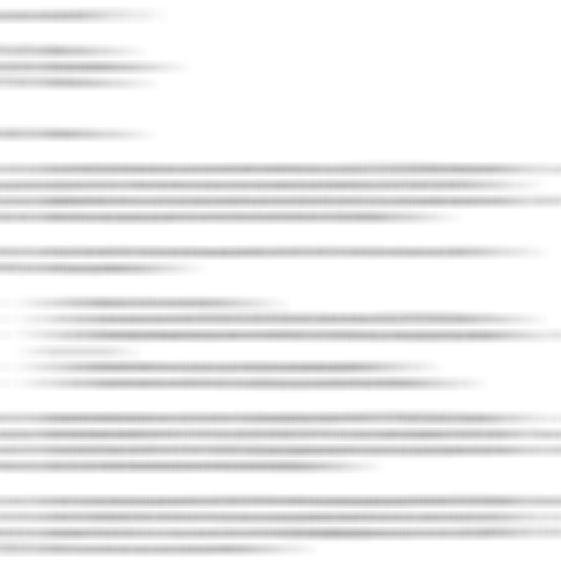

In [202]:
misc.toimage(blur)

In [203]:
tix = np.where(1-t)
tix = tix[0]

In [204]:
len(tix)

373

In [205]:
linspace = []
for x in range(tix.shape[0]-1):
    if tix[x+1] == tix[x] + 1:
        continue
    linspace.append(tix[x+1]-tix[x]-1)

In [206]:
linspace

[22, 2, 1, 39, 20, 19, 1, 20, 1, 1, 4, 5, 1, 19, 19, 1]

In [216]:
linspace_limit = 1.5*np.median(linspace)
print (linspace_limit)

6.75


In [217]:
for x in range(tix.shape[0]-1):
    if tix[x+1] == tix[x] + 1:
        continue
    if ((tix[x+1]-tix[x]) <= linspace_limit):
        for i in range(tix[x+1]-tix[x]-1):
            tix = np.append(tix, (tix[x]+i+1))

In [218]:
tix = np.sort(tix)

In [219]:
len(tix)

390

In [220]:
    lines = []
    start_ix = tix[0]
    for ix in range(1, tix.shape[0]-1):
        if tix[ix] == tix[ix-1] + 1:
            continue
        # identified gap between lines, close previous line and start a new one
        end_ix = tix[ix-1]
        lines.append([start_ix, end_ix])
        start_ix = tix[ix]
    end_ix = tix[-1]
    lines.append([start_ix, end_ix])

In [221]:
len(lines)

8

In [222]:
lines

[[9, 22],
 [45, 88],
 [128, 140],
 [161, 224],
 [244, 275],
 [296, 390],
 [410, 473],
 [493, 556]]

In [223]:
for line in lines:
    cv2.rectangle(image_sliced, (2, line[0]), (image_sliced.shape[1]-2, line[1]), (128, 128, 0), 1)

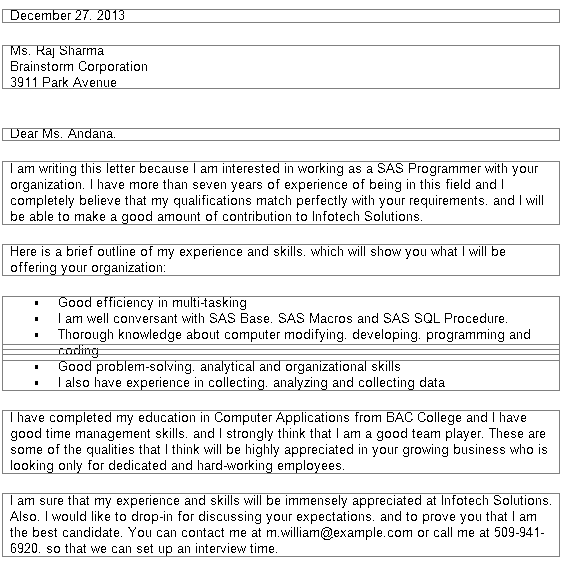

In [224]:
misc.toimage(image_sliced)

In [225]:
l_starts = []
for line in lines:
    xx = []
    for x in range(image_sliced.shape[1]):
        col = image_sliced[line[0]:line[1], x]
        if np.min(col) < 128:
            xx.append(x)
    l_starts.append((min(xx), max(xx)))

In [226]:
l_starts

[(11, 123),
 (11, 146),
 (11, 114),
 (11, 542),
 (11, 504),
 (35, 529),
 (11, 546),
 (10, 550)]

In [184]:
len(l_starts)

10

In [250]:
features = []
for i in range(len(lines)):
    cv2.rectangle(image_sliced, (l_starts[i][0]-2, lines[i][0]-2), (l_starts[i][1]+2, lines[i][1]+2), (128, 128, 0), 1)
    slc = image_sliced[lines[i][0]-2:lines[i][1]+2, l_starts[i][0]-2:l_starts[i][1]+2]
    filename = 'slice_' + str(i+1) + '.png'
    misc.imsave(filename, slc)
#     print (filename)
    ocr_txt = pytesseract.image_to_string(Image.open(filename))
    os.remove(filename)
    features.append({'flag': filename,
                    'width': (l_starts[i][1] - l_starts[i][0] + 4),
                    'heigth': (lines[i][1] - lines[i][0] + 4),
                    'seq_from_top': (i+1),
                    'seq_from_bottom': (len(lines)-i),
                    'width_prv': 0 if not i else (l_starts[i-1][1] - l_starts[i-1][0] + 4),
                    'heigth_prv': 0 if not i else (lines[i-1][1] - lines[i-1][0] + 4),
                    'width_nxt': 0 if i==len(lines)-1 else (l_starts[i+1][1] - l_starts[i+1][0] + 4),
                    'heigth_nxt': 0 if i==len(lines)-1 else (lines[i+1][1] - lines[i+1][0] + 4),
                    'text': ocr_txt
                    })

In [251]:
for i in range(len(features)):
    if features[i]['seq_from_top'] == 1:
        features[i]['type'] = 'header';
    elif ((features[i]['seq_from_bottom'] == 1) & (features[i]['width'] < (0.5 * image_sliced.shape[1]))) :
        features[i]['type'] = 'footer'
    elif ((features[i]['width'] < (0.5 * image_sliced.shape[1])) & (features[i-1]['type'] == 'header')):
        features[i]['type'] = 'header'
    else:
        features[i]['type'] = 'body'

In [252]:
for i in range(len(features)):
    if (i == len(features)-1):
        continue
    if ((features[i]['width'] < (0.5*image_sliced.shape[1])) & (features[i+1]['type'] == 'footer')):
        features[i]['type'] = 'footer'

In [253]:
features

[{'flag': 'slice_1.png',
  'heigth': 17,
  'heigth_nxt': 47,
  'heigth_prv': 0,
  'seq_from_bottom': 8,
  'seq_from_top': 1,
  'text': 'December 27. 2013',
  'type': 'header',
  'width': 116,
  'width_nxt': 139,
  'width_prv': 0},
 {'flag': 'slice_2.png',
  'heigth': 47,
  'heigth_nxt': 16,
  'heigth_prv': 17,
  'seq_from_bottom': 7,
  'seq_from_top': 2,
  'text': 'MS Fo) Shama\nBrainstorm Cororation\nB01 Park Avenue',
  'type': 'header',
  'width': 139,
  'width_nxt': 107,
  'width_prv': 116},
 {'flag': 'slice_3.png',
  'heigth': 16,
  'heigth_nxt': 67,
  'heigth_prv': 47,
  'seq_from_bottom': 6,
  'seq_from_top': 3,
  'text': 'Dear Ws: Andana',
  'type': 'header',
  'width': 107,
  'width_nxt': 535,
  'width_prv': 139},
 {'flag': 'slice_4.png',
  'heigth': 67,
  'heigth_nxt': 35,
  'heigth_prv': 16,
  'seq_from_bottom': 5,
  'seq_from_top': 4,
  'text': 'l am witing thi eter because | am interested in working as a SAS Programmer wih your\norganization 1 have more than seven years of 

In [263]:
header = ""
body = ""
footer = ""
for item in features:
    if (item['type'] == 'header'):
        header = header + '\n' + item['text']
    if (item['type'] == 'body'):
        body = body + '\n' + item['text']
    if (item['type'] == 'footer'):
        footer = footer + '\n' + item['text']

In [268]:
out_dir_file = os.path.join(dir,in_file.replace(".jpg",".txt"))
print (out_dir_file)

C:\Users\ankuarora\Desktop\Client\2017_05_CogEx\2017_07_R2Implementation\Sprint 6\SampleInputs\scanned letter 8.txt


In [272]:
with open(out_dir_file, "w") as text_file:
    print("Header: {}\n\nBody: {}\n\nFooter: {}".format(header, body, footer), file=text_file)
print (in_file.replace(".jpg",".txt") + " created successfully")

scanned letter 8.txt created successfully
